In [1]:
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


In [7]:
n_used = 100000 #data to use
dataX,dataY = [],[]
sentence, labels_sentence = [], []
lemmas,labels = set(), set()  #uniques
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX.append(sentence)
        dataY.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = dataX[1:]
dataY = dataY[1:]

In [8]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]

In [4]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
model = Word2Vec(dataX, size=EMBEDDING_DIM, window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=3, negative=5,sg=1) #sg=1 mean skip-gram
model

In [10]:
vocab_words = list(model.wv.vocab)
print("Tamano del vocabulario: ",len(vocab_words))

Tamano del vocabulario:  3144


In [5]:
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}

In [9]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
n_lemmas = len(lemmas)

dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]

In [26]:
embedding_matrix = np.zeros((n_lemmas+1, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.05347466,  0.0790691 , -0.12822857, ..., -0.26420334,
        -0.17218229,  0.02646903],
       [ 0.10988804,  0.10135647, -0.17103973, ..., -0.37504655,
        -0.27834073,  0.06954294],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
X.shape

(4543, 34)

In [27]:
embedding_matrix.shape

(7513, 32)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

In [24]:
X_train.shape

(3180, 34)

In [29]:
embedding_matrix.shape

(7513, 32)

In [31]:
n_lemmas+=1
n_labels+=1

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=34,trainable=False,
                   weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 34, 32)            240416    
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 34, 18)            1818      
Total params: 295,434
Trainable params: 55,018
Non-trainable params: 240,416
_________________________________________________________________
Train on 3180 samples, validate on 1363 samples
Epoch 1/10
3180/3180 [==============================] - 4s 1ms/step - loss: 2.0487 - val_loss: 1.6018
Epoch 2/10
3180/3180 [==============================] - 2s 547us/step - loss: 1.3990 - val_loss: 1.1465
Epoch 3/1

In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

Using TensorFlow backend.


In [2]:
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255. #and x_test

#...#Define here your validation set
import keras
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [41]:
x_train.max()

1.0

In [69]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded = Dense(32, activation='relu')(input_fl)
decoded = Dense(np.prod(original_img_size), activation='sigmoid')(encoded)
decoded = Reshape(original_img_size)(decoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,validation_data=(x_test,x_test))
autoencoder.save('basic_autoencoder.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 5216/60000 [=>............................] - ETA: 8s - loss: 0.2853

KeyboardInterrupt: 

In [68]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPooling2D, UpSampling2D
input_img = Input(shape=original_img_size)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)
x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
x = Reshape(before_F_shape)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.summary()
autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,validation_data=(x_test,x_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                50208     
__________

KeyboardInterrupt: 

(7, 7, 32)

In [26]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               25872     
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [ ]:
??

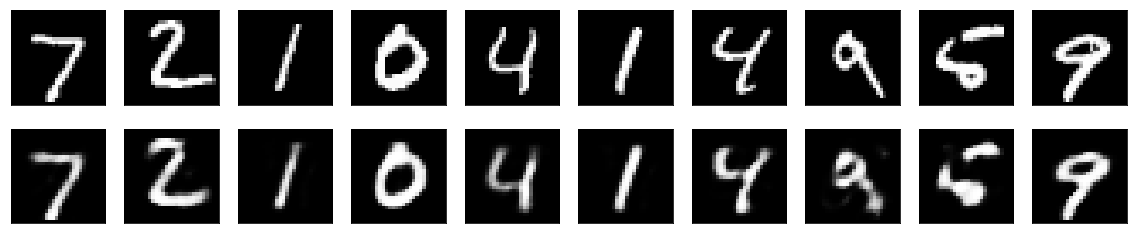

In [45]:
#encoded_test = encoder.predict(x_test)
#decoded_test = decoder.predict(encoded_test)
decoded_test = autoencoder.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128

#cambia
latent_dim = 10

x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)

#cambio..
logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
encoder = Model(x, logits_z) # build a model to project inputs on the latent space


In [11]:
import keras.backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

In [14]:
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return - K.log( -K.log(U + eps) + eps)
        
def sampling(logits_z):
    """ Perform a Gumbel-Softmax sampling"""
    tau = K.variable(2/3, name="temperature") 
    z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
    return keras.activations.softmax( z/tau )    

from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))(logits_z)
#para arriba cambio...

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
__________

In [15]:
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss

#KL cambia:
dist =  keras.activations.softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)

vae_norm.add_loss(vae_loss)
vae_norm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
__________

In [153]:
batch_size = 64
epochs =  25
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.
  app.launch_new_instance()


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 18s 301us/step - loss: 138.1076 - val_loss: 138.6182
Epoch 2/25
60000/60000 [==============================] - 17s 280us/step - loss: 137.1350 - val_loss: 139.8848
Epoch 3/25
60000/60000 [==============================] - 17s 281us/step - loss: 136.3050 - val_loss: 135.7248
Epoch 4/25
60000/60000 [==============================] - 17s 280us/step - loss: 135.5400 - val_loss: 136.2309
Epoch 5/25
60000/60000 [==============================] - 17s 279us/step - loss: 134.9025 - val_loss: 134.9311
Epoch 6/25
60000/60000 [==============================] - 17s 279us/step - loss: 134.4601 - val_loss: 135.2788
Epoch 7/25
60000/60000 [==============================] - 17s 279us/step - loss: 133.7722 - val_loss: 133.9731
Epoch 8/25
60000/60000 [==============================] - 17s 282us/step - loss: 133.3055 - val_loss: 133.6667
Epoch 9/25
60000/60000 [==============================] - 17s 

In [154]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1,keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)
p_z_train = softmax(encoder.predict(x_train))
p_z_test = softmax(encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)
p_z_test

array([[9.93214577e-09, 3.42115709e-05, 3.34711804e-05, ...,
        9.18326557e-01, 7.88376778e-02, 1.22381802e-08],
       [5.01510799e-02, 1.18385833e-04, 1.04509264e-01, ...,
        2.30292767e-06, 2.50481698e-05, 2.21619487e-01],
       [4.96984764e-09, 2.85342723e-01, 7.14640677e-01, ...,
        8.22795391e-06, 9.44979983e-10, 4.77221238e-06],
       ...,
       [2.92682046e-07, 3.96850646e-01, 3.09091178e-03, ...,
        4.07346815e-01, 6.24903696e-05, 1.12699415e-03],
       [1.94816457e-05, 1.52378857e-06, 4.45192470e-08, ...,
        6.37474470e-03, 8.71460512e-03, 2.05271999e-06],
       [3.02969944e-04, 6.97063399e-07, 1.66004733e-03, ...,
        5.49713430e-09, 4.10732959e-08, 1.04517244e-06]], dtype=float32)

In [155]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))


0.31587453023976225
0.323335570035452


In [156]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 

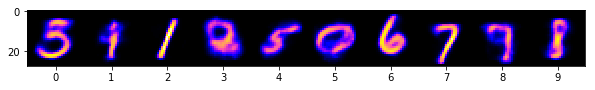

In [157]:
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:, i * img_cols: (i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

In [173]:
import numpy as np
import os
folder = "/home/fmena/Desktop/ML_usm/Ayud_ANN/Tarea2/data/Semantic dataset100"

data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]

from PIL import Image
X_image = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize( (80,80),Image.ANTIALIAS ))
    X_image.append(I)
X_image = np.asarray(X_image)
X_image.shape

(100, 80, 80, 3)

In [174]:
Y_image = []
for archivo in data:
    I = Image.open(folder+"/ground-truth/"+archivo+".png")
    I = np.asarray(I.resize( (80,80),Image.ANTIALIAS ))
    Y_image.append(I)
Y_image = np.asarray(Y_image)
Y_image.shape

(100, 80, 80)

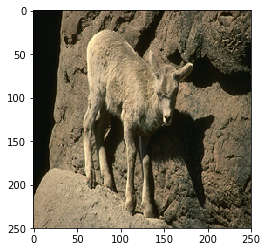

In [71]:
import matplotlib.pyplot as plt
plt.imshow(X_image[0])
plt.show()

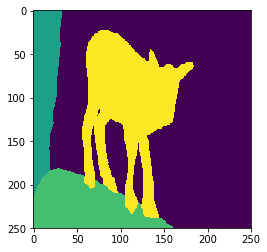

In [79]:
plt.imshow(Y_image[0])
plt.show()

In [176]:
#https://arxiv.org/pdf/1511.00561v2.pdf 

from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization

model = Sequential()

#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_image.shape[1:]))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(MaxPool2D((2, 2), strides=(2,2)))

#DECODER PART
#model.add(UpSampling2d((2, 2), strides=(2,2)))
#model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())

#model.add(UpSampling2D((2, 2)))

#model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())

#model.add(UpSampling2D((2, 2)))
#model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())

#model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

#una que lleve a size original??
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 80, 80, 32)        896       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 20, 20, 128)       73856     
__________

In [178]:
X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]

In [179]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
model.fit(X_image,Y_image,epochs=100,batch_size=32)

Epoch 1/100
100/100 [==============================] - 4s 44ms/step - loss: 0.7068
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 0.7599
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6708
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6360
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6479
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6578
Epoch 7/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6457
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6123
Epoch 9/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6435
Epoch 10/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6361
Epoch 11/100
100/100 [==============================] - 0s 1ms/step - loss: 0.5993
Epoch 12/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6154
Epoch 13/100

In [180]:
Y_hat = np.squeeze( model.predict(X_image))
Y_hat

array([[[0.05108603, 0.0462476 , 0.03700586, ..., 0.09741623,
         0.08527576, 0.09741623],
        [0.05603036, 0.0394941 , 0.0201833 , ..., 0.0763008 ,
         0.05944319, 0.0763008 ],
        [0.03904895, 0.02138425, 0.02411032, ..., 0.05314611,
         0.05611108, 0.05314611],
        ...,
        [0.31772795, 0.26154277, 0.24046957, ..., 0.29150397,
         0.2885826 , 0.29150397],
        [0.2984385 , 0.25497612, 0.24359964, ..., 0.28677422,
         0.29162857, 0.28677422],
        [0.31772795, 0.26154277, 0.24046957, ..., 0.29150397,
         0.2885826 , 0.29150397]],

       [[0.14945522, 0.1427985 , 0.12788102, ..., 0.24193178,
         0.22179037, 0.24193178],
        [0.16169529, 0.13173865, 0.0980425 , ..., 0.20985115,
         0.19496804, 0.20985115],
        [0.12947047, 0.09477232, 0.10107353, ..., 0.18168516,
         0.1732395 , 0.18168516],
        ...,
        [0.3375127 , 0.2839663 , 0.26879236, ..., 0.17884172,
         0.1779175 , 0.17884172],
        [0.3

In [188]:
n_s = 1

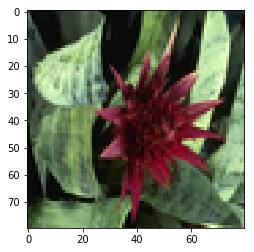

In [189]:
import matplotlib.pyplot as plt
plt.imshow(X_image[n_s],cmap='gray')
plt.show()

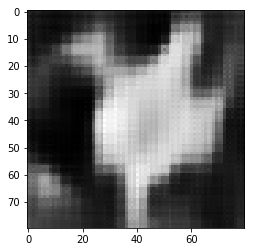

In [190]:
import matplotlib.pyplot as plt
plt.imshow(Y_hat[n_s],cmap='gray')
plt.show()

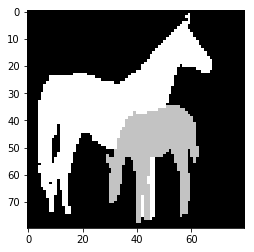

In [184]:
plt.imshow(np.squeeze(Y_image[n_s]),cmap='gray')
plt.show()

In [151]:
### denoising??
from numpy.random import binomial
T = 100
for _ in range(T):
    noise_level = np.random.randint(4,10)/10.
    noise_mask = binomial(n=1,p=noise_level,size=X_image.shape)
    X_augmented = X_image*noise_mask
    model.fit(X_augmented,Y_image,epochs=1,batch_size=32,validation_data=(X_image,Y_image))

Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 2s 18ms/step - loss: 0.5971 - acc: 0.5802 - val_loss: 0.5624 - val_acc: 0.5890
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.6110 - acc: 0.5741 - val_loss: 0.5524 - val_acc: 0.5895
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5428 - acc: 0.6044 - val_loss: 0.5863 - val_acc: 0.5763
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5561 - acc: 0.5964 - val_loss: 0.5619 - val_acc: 0.5951
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5562 - acc: 0.5957 - val_loss: 0.6098 - val_acc: 0.5650
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - l

100/100 [==============================] - 0s 4ms/step - loss: 0.5030 - acc: 0.6196 - val_loss: 0.5780 - val_acc: 0.5889
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.4985 - acc: 0.6205 - val_loss: 0.6456 - val_acc: 0.5712
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5116 - acc: 0.6104 - val_loss: 0.5714 - val_acc: 0.5952
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.4970 - acc: 0.6225 - val_loss: 0.6431 - val_acc: 0.5744
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5210 - acc: 0.6086 - val_loss: 0.6997 - val_acc: 0.5502
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.5144 - acc: 0.6120 - val_loss: 1.0921 - val_acc: 0

In [172]:
from sklearn.metrics import precision_score, recall_score
Y_label = Y_hat.flatten() >0.5
Y_hat_label = Y_image.flatten() >0.5
print(precision_score(Y_label, Y_hat_label, average='macro' ))
print(recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))


0.6691001021067786
[0.76401647 0.84546099]


In [1]:
import pandas as pd
df_train = pd.read_csv("data/cv-valid-train.csv")
df_valid = pd.read_csv("data/cv-valid-dev.csv")
df_test = pd.read_csv("data/cv-valid-test.csv")

df_train.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [2]:
df_train = df_train.iloc[:10000]
df_train.shape

(10000, 8)

In [4]:
##audio files...
import librosa
SAMPLING_RATE = 22050
RESAMPLING_RATE = 2000 #500  es como tomar saltos cada 100
def load_wav_file(name, path):
    """ This could take a while :D"""
    i = int(name.split("sample-")[-1][:-4])
    if i%500==0:
        print("procesaron 500, va en ",i)
    y, sr = librosa.load(path + name,mono=True)
    return librosa.resample(y, sr, RESAMPLING_RATE) #y[::50] #resampling of xx 100 quizas es mucho... 

timeseries_train = df_train['filename'].apply(load_wav_file, path='data/').values
timeseries_valid = df_valid['filename'].apply(load_wav_file, path='data/').values
timeseries_test = df_test['filename'].apply(load_wav_file, path='data/').values
timeseries_valid.shape

procesaron 500, va en  0
procesaron 500, va en  500


KeyboardInterrupt: 

In [15]:
import numpy as np
np.save("timeseries_train.npy", timeseries_train)
np.save("timeseries_valid.npy", timeseries_valid)
np.save("timeseries_test.npy", timeseries_test)

In [3]:
import numpy as np
import librosa
timeseries_train = np.load("timeseries_train.npy")
timeseries_valid = np.load("timeseries_valid.npy")
timeseries_test = np.load("timeseries_test.npy")

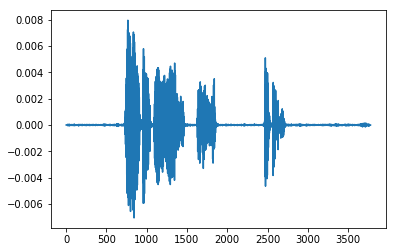

In [36]:
import matplotlib.pyplot as plt
plt.plot(timeseries_train[1])
plt.show()

In [4]:
max_data = np.max([audio.max() for audio in timeseries_train]) #np.max(timeseries_train)
min_data = np.min([audio.min() for audio in timeseries_train])
def audio_norm(data):
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5
timeseries_train = audio_norm(timeseries_train)
timeseries_valid = audio_norm(timeseries_valid)
timeseries_test = audio_norm(timeseries_test)

In [5]:
from keras.preprocessing import sequence
###MUY IMPORTANTE DECIDA SOBRRE QUÉ VALOR 
max_inp_length = max(map(len,timeseries_train))
X_train = sequence.pad_sequences(timeseries_train, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_valid = sequence.pad_sequences(timeseries_valid, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_test = sequence.pad_sequences(timeseries_test, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_train.shape

Using TensorFlow backend.


(10000, 12433)

In [6]:
X_train_scaled = X_train.copy() #scaler.fit_transform(X_train)
X_valid_scaled = X_valid.copy() #scaler.transform(X_valid)
X_test_scaled = X_test.copy() #scaler.transform(X_test)

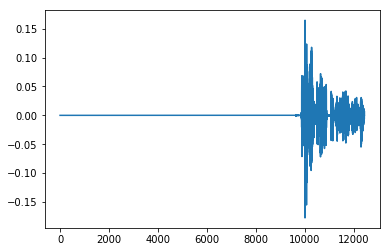

In [10]:
#visualice lo k pasa
import matplotlib.pyplot as plt
plt.plot(X_train[20])
plt.show()

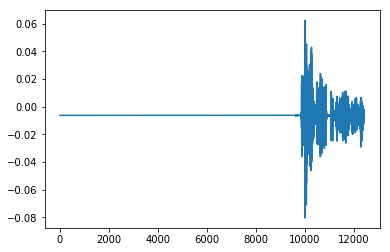

In [9]:
plt.plot(X_train_scaled[20])
plt.show()

In [6]:
from keras.preprocessing import sequence
###MUY IMPORTANTE DECIDA SOBRRE QUÉ VALOR 
max_inp_length = max(map(len,timeseries_train))
X_train = sequence.pad_sequences(timeseries_train, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_valid = sequence.pad_sequences(timeseries_valid, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_test = sequence.pad_sequences(timeseries_test, maxlen=max_inp_length,padding='pre',value=0,dtype='float32')
X_train.shape

(10000, 12433)

In [7]:
max_data = np.max(X_train) 
min_data = np.min(X_train)
def audio_norm(data):
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5
X_train_scaled = audio_norm(X_train)
X_valid_scaled = audio_norm(X_valid)
X_test_scaled = audio_norm(X_test)

In [11]:
from keras.preprocessing.text import text_to_word_sequence
#add end sentence symbol
symbol_end = "#END"
raw_text_train = [text_to_word_sequence(value)+[symbol_end] for  value in df_train["text"]]
raw_text_valid = [text_to_word_sequence(value)+[symbol_end] for  value in df_valid["text"]]
raw_text_test = [text_to_word_sequence(value)+[symbol_end] for  value in df_test["text"]]

#crear vocabulario-- solo en train-- que pasa s iagregamos palabras de test o valid?
count_vocab = {}
for sentence in raw_text_train:
    for word in sentence:
        if word not in count_vocab:
            count_vocab[word] = 1
        else:
            count_vocab[word] += 1
#achicar vocabulario...
min_count = 3
vocab_text = [word for word,count in count_vocab.items() if count >= min_count]
        
word2idx = {w: i for i, w in enumerate(vocab_text)} #Converting text to numbers
idx2word = {i: w for i, w in enumerate(vocab_text)} #Converting number to text
n_words = len(vocab_text)

dataY_train = [[word2idx[word] for word in sentence if word in word2idx] for sentence in raw_text_train]
dataY_valid = [[word2idx[word] for word in sentence if word in word2idx] for sentence in raw_text_valid] #que propongan algo aca
dataY_test = [[word2idx[word] for word in sentence  if word in word2idx] for sentence in raw_text_test]

#padding..
from keras.preprocessing import sequence
max_out_length = max(map(len,dataY_train)) #si cambiamos esto en que afecta al modelo neurona?? (no cambia parametros :o)

word2idx["?"] = n_words #padding symbol
idx2word[n_words] = "?"
n_words+=1

y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx["?"])
y_valid = sequence.pad_sequences(dataY_valid, maxlen=max_out_length, padding='post', value=word2idx["?"])
y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx["?"])
print("Vocabulario: ",n_words)
print("Largo max: ",max_out_length)
y_train.shape

Vocabulario:  2613
Largo max:  32


(10000, 32)

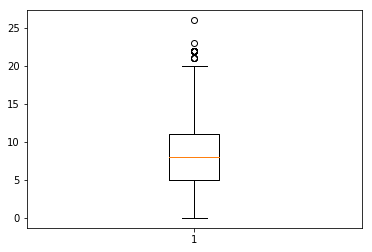

In [11]:
import matplotlib.pyplot as plt
plt.boxplot(list(map(len,dataY_train)))
plt.show()

In [12]:
#add extra dim
X_train_scaled = X_train_scaled[:,:,None]
X_valid_scaled = X_valid_scaled[:,:,None]
X_test_scaled= X_test_scaled[:,:,None]

y_train = y_train[:,:,None]
y_valid = y_valid[:,:,None]
y_test = y_test[:,:,None]

In [13]:
from keras.models import Sequential
from keras.layers import CuDNNGRU,RepeatVector,TimeDistributed, Dense
model = Sequential()
#ENCODER PART
model.add(CuDNNGRU(16, return_sequences=True, input_shape=(max_inp_length,1)))
model.add(CuDNNGRU(32, return_sequences=False))
model.add(RepeatVector(max_out_length)) #Conection
#DECODER PART
model.add(CuDNNGRU(32, return_sequences=True))
model.add(CuDNNGRU(16, return_sequences=True))
model.add(TimeDistributed(Dense(n_words, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 12433, 16)         912       
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 32)                4800      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 32, 32)            0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 32, 32)            6336      
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32, 16)            2400      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 2613)          44421     
Total params: 58,869
Trainable params: 58,869
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.fit(X_train_scaled ,y_train, epochs=3, batch_size=256,validation_data=(X_valid_scaled,y_valid))

Train on 10000 samples, validate on 4076 samples
Epoch 1/5
  256/10000 [..............................] - ETA: 31:44 - loss: 8.5071

KeyboardInterrupt: 

import keras
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, df, path, list_IDs,labels, batch_size=32, T_inp=10, T_out=10,shuffle=True):
        'Initialization'
        self.df = df
        self.path = path
        self.T_out = T_out
        self.T_inp = T_inp
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.labels = labels
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.T_inp))
        y = np.empty((self.batch_size, self.T_out), dtype=int)

        # Generate data
        aux = []
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            timeseries = load_wav_file(self.df["filename"][ID], self.path)
            timeseries = audio_norm(timeseries) #normalize [-0.5,0.5]
            #aux.append(timeseries)
            X_aux = sequence.pad_sequences([timeseries],maxlen=self.T_inp,padding='pre',value=0,dtype='float32') 
            #or  add padding and then normalize...
            X[i,] = X_aux

            # Store class
            y[i] = self.labels[ID]
        #T_batch = max(map(len,aux))
        #X = sequence.pad_sequences(aux,maxlen=T_batch,padding='pre',value=0,dtype='float32') 
        #print(X.shape)
        return np.expand_dims(X, axis=-1), np.expand_dims(y ,axis=-1)
    
import librosa
SAMPLING_RATE = 22050
RESAMPLING_RATE = 2000 #500  es como tomar saltos cada 100
def load_wav_file(name, path):
    """ This could take a while :D"""
    y, sr = librosa.load(path + name,mono=True)
    return librosa.resample(y, sr, RESAMPLING_RATE)

def audio_norm(data):
    max_data = 1.2
    min_data = -1.2
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5
 
from keras.preprocessing import sequence

In [25]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization,Dropout
model = Sequential()
#ENCODER PART
model.add(Conv1D(8, 11, padding='same', activation='relu', strides=1,input_shape=(max_inp_length,1)))
model.add(BatchNormalization())
model.add(Conv1D(8, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
#model.add(GlobalAveragePooling1D()) #experimente
model.add(RepeatVector(max_out_length)) #Conection
#DECODER PART
gated_layer = CuDNNGRU(16, return_sequences=True)
from keras.layers import Bidirectional
model.add(Bidirectional(gated_layer,merge_mode='concat'))
model.add(Dropout(0.25))
gated_layer = CuDNNGRU(8, return_sequences=True)
model.add(Bidirectional(gated_layer,merge_mode='concat'))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(n_words, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 12433, 8)          96        
_________________________________________________________________
batch_normalization_7 (Batch (None, 12433, 8)          32        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12433, 8)          712       
_________________________________________________________________
batch_normalization_8 (Batch (None, 12433, 8)          32        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2486, 8)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2486, 16)          1424      
_________________________________________________________________
batch_normalization_9 (Batch (None, 2486, 16)          64        
__________

In [15]:
# simpler
model = Sequential()
#ENCODER PART
model.add(Conv1D(8, 11, padding='same', activation='relu', strides=1,input_shape=(max_inp_length,1)))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
#model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model.add(GlobalAveragePooling1D()) #experimente
model.add(RepeatVector(max_out_length)) #Conection
#DECODER PART
model.add(CuDNNGRU(16, return_sequences=True))
model.add(Dropout(0.25))
model.add(CuDNNGRU(8, return_sequences=True))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(n_words, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 12433, 8)          96        
_________________________________________________________________
batch_normalization_5 (Batch (None, 12433, 8)          32        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2486, 8)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2486, 16)          1424      
_________________________________________________________________
batch_normalization_6 (Batch (None, 2486, 16)          64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 497, 16)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
__________

In [ ]:
model.add(Conv1D(8, 11, padding='same', activation='relu', strides=1,input_shape=(max_inp_length,1)))
model.add(BatchNormalization())
model.add(Conv1D(8, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(Conv1D(32, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(Conv1D(32, 11, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(5))
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False
#model.add(GlobalAveragePooling1D()) #experimente

model.add(RepeatVector(max_out_length)) #Conection

#DECODER PART
gated_layer = CuDNNGRU(16, return_sequences=True)
from keras.layers import Bidirectional
model.add(Bidirectional(gated_layer,merge_mode='concat'))
#model.add(gated_layer)
model.add(Dropout(0.25))
gated_layer = CuDNNGRU(8, return_sequences=True)
model.add(Bidirectional(gated_layer,merge_mode='concat'))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(n_words, activation='softmax')))
model.summary()

In [16]:
#revisar un forward inicializado.. #quizas quede muy estancado al principio...
model.predict_classes(X_test_scaled)


array([[1891, 1891, 1891, ..., 1891, 1891, 1891],
       [1891, 1891, 1891, ..., 1891, 1891, 1891],
       [ 127,  127, 1891, ..., 1891, 1891, 1891],
       ...,
       [ 127,  127, 1891, ..., 1891, 1891, 1891],
       [1891, 1891, 1891, ..., 1891, 1891, 1891],
       [ 127,  127, 1891, ..., 1891, 1891, 1891]])

In [17]:
from sklearn.utils.class_weight import compute_class_weight
valid_labels = np.arange(n_words)
c_weights = compute_class_weight('balanced', classes=valid_labels, y=y_train.flatten())
c_weights[-1] = 0 #padding class masked
c_weights

array([40.82153336,  6.44550527,  3.40179445, ..., 40.82153336,
       40.82153336,  0.        ])

In [18]:
sample_weight = np.zeros(y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[y_train[i,:]]
sample_weight = np.squeeze(sample_weight)
sample_weight.shape

(10000, 32)

In [ ]:
dic_weight = dict(zip(valid_labels,c_weights)) #{label:weight for label,weight in  zip(valid_labels,c_weights)}
dic_weight

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(X_train_scaled ,y_train, epochs=15, batch_size=256,validation_data=(X_valid_scaled,y_valid),
         class_weight = dic_weight)

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model.fit(X_train_scaled ,y_train, epochs=10, batch_size=256,validation_data=(X_valid_scaled,y_valid),
         sample_weight = sample_weight)

Train on 10000 samples, validate on 4076 samples
Epoch 1/10
10000/10000 [==============================] - 15s 2ms/step - loss: 24.8437 - val_loss: 7.9483
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.8312 - val_loss: 7.9618
Epoch 3/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.8138 - val_loss: 8.0359
Epoch 4/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.7875 - val_loss: 8.0596
Epoch 5/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.7474 - val_loss: 8.1471
Epoch 6/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.6864 - val_loss: 8.2369
Epoch 7/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.6162 - val_loss: 8.4589
Epoch 8/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.5500 - val_loss: 8.4255
Epoch 9/10
10000/10000 [==============================] - 11s 1ms/step - loss: 24.4491 - val_loss: 8.58

In [27]:
y_hat_valid = model.predict_classes(X_valid_scaled)
y_hat_test = model.predict_classes(X_test_scaled)
y_hat_valid

array([[2561, 2561, 2561, ..., 2290, 2323, 2323],
       [2561, 2561,  237, ..., 2290, 2323, 2323],
       [2158, 2158, 2158, ...,  673,  673, 2323],
       ...,
       [2561, 2561,  237, ..., 2323, 2323, 2323],
       [2561, 2561, 2561, ..., 2323, 2323, 2323],
       [2561, 2561, 2561, ..., 1496, 1496, 1496]])

In [21]:
y_hat_valid = model.predict_classes(X_valid_scaled)
y_hat_test = model.predict_classes(X_test_scaled)
y_hat_valid

#al predecir cortar cuando aparezca el simbolo #END...
def predict_words(y_indexs):
    return_val = []
    for indx_word in y_indexs:
        return_val.append(np.squeeze(indx_word))
        if indx_word == word2idx["#END"]: #stop predicting
            return return_val
    return return_val

In [28]:
#exact match.. y f1 score (que tantas palabras entregadas son ocupadas y que tantas palabras faltaron)...
#?? como se evalua?? -- proponga alguna tecnica..--- dificil BLEU

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([valid_labels])
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])
    binarized_pred = m.transform([predict_words(pred)]) #onehot of words appear... (no cuenta las veces que aparece la palabra..)
    return f1_score(binarized_true, binarized_pred, average='macro')
np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(y_valid,y_hat_valid)])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.00024853087923408545

In [29]:
import numpy as np
import IPython.display as ipd

def visualize(y_set,y_set_pred,df):
    n_sampled = np.random.randint(y_set.shape[0])
    display(ipd.Audio("data/"+ df['filename'][n_sampled])) # load a local WAV file
    text_real = [idx2word[p] for p in predict_words(y_set[n_sampled,:,0])]
    print("Texto real: ", ' '.join( text_real))
    p_sampled = predict_words(y_set_pred[n_sampled])
    text_sampled = [idx2word[p] for p in p_sampled]
    print("Texto predicho: ", ' '.join(text_sampled))

In [30]:
visualize(y_test,y_hat_test,df_test)

Texto real:  and don't forget to make him wear his in london #END
Texto predicho:  i i i i there's replace replace replace prodded prodded prodded tracts tracts kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness kindness perform


In [110]:
y_hat_train = model.predict_classes(X_train_scaled)


In [115]:
visualize(y_train,y_hat_train,df_train)

Texto real:  they're not my sheep anymore he said to himself without nostalgia #END
Texto predicho:  plumber tightened wasted requires requires challenges lawsuits lawsuits lawsuits lawsuits pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit pit


In [ ]:
#reemplazar encoder por modelo implicito de extraccion de caract.

1- Fourier + pca
2- MMCC

In [23]:
#MANUALLY--ENCODER PART

#Fourier
X_train_fourier = np.abs(np.fft.fft(X_train))
X_valid_fourier = np.abs(np.fft.fft(X_valid))
X_test_fourier = np.abs(np.fft.fft(X_test))
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
X_train_fourier = std.fit_transform(X_train_fourier)
X_valid_fourier = std.transform(X_valid_fourier)
X_test_fourier = std.transform(X_test_fourier)

from sklearn.decomposition import PCA
d = 32 #as other models
pca_model = PCA(n_components=d)
X_pca_train = pca_model.fit_transform(X_train_fourier)
X_pca_valid = pca_model.transform(X_valid_fourier)
X_pca_test = pca_model.transform(X_test_fourier)

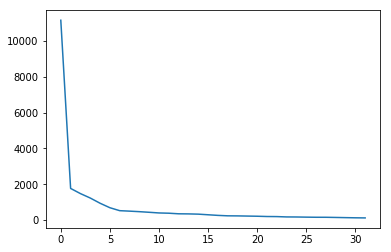

In [113]:
plt.plot(pca_model.explained_variance_)

In [140]:
#MFCC
import librosa
def wav2mfcc(wave, d, max_pad_len=11):
    mfcc = librosa.feature.mfcc(wave,n_mfcc = d, sr = SAMPLING_RATE)
    return mfcc.max(axis=-1) #Globalmaxpooling

d = 32 #as other models
X_mfcc_train = np.asarray([wav2mfcc(value,d) for value in timeseries_train ])
X_mfcc_valid = np.asarray([wav2mfcc(value,d) for value in timeseries_valid ])
X_mfcc_test = np.asarray([wav2mfcc(value,d) for value in timeseries_test ])
X_mfcc_valid.shape

(100, 32)

In [24]:
from keras.layers import InputLayer
model = Sequential()
model.add(InputLayer(input_shape=(d,)))
model.add(RepeatVector(max_out_length)) #Conection
#DECODER PART
model.add(GRU(32, return_sequences=True))
model.add(GRU(16, return_sequences=True))
model.add(TimeDistributed(Dense(n_words, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 34, 32)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 34, 32)            6240      
_________________________________________________________________
gru_10 (GRU)                 (None, 34, 16)            2352      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 34, 4927)          83759     
Total params: 92,351
Trainable params: 92,351
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.fit(X_mfcc_train ,y_train, epochs=10, batch_size=256, validation_data=(X_mfcc_valid,y_valid))

Train on 100 samples, validate on 100 samples
Epoch 1/10
100/100 [==============================] - 2s 24ms/step - loss: 8.3672 - val_loss: 8.3458
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 8.3502 - val_loss: 8.3264
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 8.3299 - val_loss: 8.3055
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 8.3084 - val_loss: 8.2839
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 8.2856 - val_loss: 8.2613
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 8.2617 - val_loss: 8.2384
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 8.2376 - val_loss: 8.2149
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 8.2129 - val_loss: 8.1908
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 8.1877 - val_loss: 8.1668
Epoch 10/10
100/100 [==============================] 

In [1]:
import pandas as pd
df = pd.read_csv("data/spa.txt", sep="\t",names=["Source","Target"])
print(df.shape)
df.head()

(120614, 2)


,Source,Target
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [3]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where):
    """Sin eliminar el significado de las palabras.."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()]
    if where=="source":
        return tokenize_text #remove numbers
    elif where =="target":
        return tokenize_text + ["#end"] #remove numbers
    
texts_input = list(df['Source'].apply(clean_text, where='source'))
texts_output = list(df['Target'].apply(clean_text, where='target'))

In [4]:
#split en un inicio...
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output, test_size=10000,random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, test_size=10000,random_state=22)

print(len(X_train_l))
print(len(X_val_l))
print(len(X_test_l))

100614
10000
10000


In [21]:
a = [[1,1],[0,1,3]]
b = [[0,1],[1,2,3]]
from sklearn.metrics import f1_score
f1_score(a[1],b[1] ,average='macro')

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.25

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,token_pattern=None)
                        #use_idf= True, smooth_idf=True)   
X_train_tfidf = tf_idf.fit_transform(dataX_train)
X_train_tfidf = X_train_tfidf.astype('float32').todense()
#X_val_tfidf = tf_idf.transform(dataX_valid).todense()

X_train_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
import gc
del tf_idf
gc.collect()

71

In [6]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]

In [7]:
#crear vocabulario-- solo en train-- que pasa s iagregamos palabras de test o valid?
vocab_source = set()
for sentence in X_train_l:
    for word in sentence:
        vocab_source.add(word)
vocab_target = set()
for sentence in Y_train_l:
    for word in sentence:
        vocab_target.add(word)

vocab_source = create_vocab(X_train_l, min_count=3) #tiene efecto??
vocab_target = create_vocab(Y_train_l, min_count=3)


word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #Converting text to numbers
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)} #Converting number to text
n_words_s = len(vocab_source)
dataX_train = [[word2idx_s[word] for word in sentence if word in word2idx_s] for sentence in X_train_l]
dataX_valid = [[word2idx_s[word] for word in sentence if word in word2idx_s] for sentence in X_val_l] #que propongan algo aca
dataX_test =  [[word2idx_s[word] for word in sentence if word in word2idx_s] for sentence in X_test_l]

word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)} #Converting text to numbers
idx2word_t = {i+1: w for i, w in enumerate(vocab_target)} #Converting number to text
n_words_t = len(vocab_target)
dataY_train = [[word2idx_t[word] for word in sentence if word in word2idx_t] for sentence in Y_train_l]
dataY_valid = [[word2idx_t[word] for word in sentence if word in word2idx_t] for sentence in Y_val_l] #que propongan algo aca
dataY_test =  [[word2idx_t[word] for word in sentence if word in word2idx_t] for sentence in Y_test_l]

print("Vocabulario inp: ",n_words_s)
print("Vocabulario out: ",n_words_t)

Vocabulario inp:  6568
Vocabulario out:  10082


In [6]:
from keras.preprocessing import sequence

### INPUT DATA (Origin language)
max_inp_length = max(map(len,dataX_train))
word2idx_s["?"] = 0 #padding symbol
idx2word_s[0] = "?"
n_words_s += 1  
#padding..
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["?"])
X_valid = sequence.pad_sequences(dataX_valid, maxlen=max_inp_length, padding='pre', value=word2idx_s["?"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["?"])
print("Vocabulario inp: ",n_words_s)
print("Largo max inp: ",max_inp_length)

### OUTPUT DATA (Destination language)
max_out_length = max(map(len,dataY_train)) #si cambiamos esto en que afecta al modelo neurona?? (no cambia parametros :o)
word2idx_t["?"] = 0 #padding symbol
idx2word_t[0] = "?"
n_words_t += 1  
#padding..
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["?"])
Y_valid = sequence.pad_sequences(dataY_valid, maxlen=max_out_length, padding='post', value=word2idx_t["?"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["?"])
print("Vocabulario out: ",n_words_t)
print("Largo max out: ",max_out_length)
#y_train.shape
X_train.shape

Using TensorFlow backend.


Vocabulario inp:  6569
Largo max inp:  45
Vocabulario out:  10083
Largo max out:  51


(100614, 45)

In [7]:
X_train

array([[    0,     0,     0, ...,  8399,  7356, 11279],
       [    0,     0,     0, ...,  6666,  5363,  3800],
       [    0,     0,     0, ...,  3152, 11281, 11084],
       ...,
       [    0,     0,     0, ...,  2885,  5363,  2233],
       [    0,     0,     0, ...,  7905,  5363,  8386],
       [    0,     0,     0, ...,  4397,  1355,  7557]], dtype=int32)

In [8]:
#valid_labels = np.arange(n_words_t)
import numpy as np
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
c_weights

array([0., 1., 1., ..., 1., 1., 1.])

In [9]:
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]
sample_weight = np.squeeze(sample_weight)
sample_weight.shape

(100614, 51)

In [10]:
Y_train = Y_train[:,:,None]
Y_valid = Y_valid[:,:,None]
Y_test = Y_test[:,:,None]
Y_train.shape

(100614, 51, 1)

In [11]:
EMBEDDING_DIM = 100

In [12]:
from keras.models import Sequential
from keras.layers import Embedding,CuDNNGRU, RepeatVector, TimeDistributed, Dense

model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
#                    trainable=False, weights = [embedding_matrix]))
model.add(CuDNNGRU(32, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=False))

model.add(RepeatVector(max_out_length)) #conection

model.add(CuDNNGRU(64, return_sequences=True)) #bidireccional??
model.add(CuDNNGRU(32, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 100)           656900    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 45, 32)            12864     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                18816     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 51, 64)            0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 51, 64)            24960     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 51, 32)            9408      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 51, 10083)         332739    
Total para

In [37]:
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
#                    trainable=False, weights = [embedding_matrix]))
model.add(CuDNNGRU(64, return_sequences=False))

model.add(RepeatVector(max_out_length)) #conection

model.add(CuDNNGRU(64, return_sequences=True)) #bidireccional??
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 45, 64)            356416    
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       (None, 64)                24960     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 50, 64)            0         
_________________________________________________________________
cu_dnngru_8 (CuDNNGRU)       (None, 50, 64)            24960     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 8166)          530790    
Total params: 937,126
Trainable params: 937,126
Non-trainable params: 0
_________________________________________________________________


In [13]:
#red conv en Encoder
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization,Dropout
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
#                    trainable=False, weights = [embedding_matrix]))

model.add(Conv1D(100, 5, padding='same', activation='relu', strides=1)) # o 3 kernel
model.add(BatchNormalization())
model.add(Conv1D(100, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Conv1D(200, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
model.add(Conv1D(200, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())

model.add(GlobalMaxPooling1D()) #aka to return_sequences=False

model.add(RepeatVector(max_out_length)) #conection

model.add(CuDNNGRU(200, return_sequences=True))
model.add(CuDNNGRU(100, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 100)           656900    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 45, 100)           50100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 100)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 100)           50100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 100)           400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 200)           100200    
__________

In [47]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization,Dropout
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
#                    trainable=False, weights = [embedding_matrix]))

model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1)) # o 3 kernel
model.add(BatchNormalization())
model.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model.add(BatchNormalization())
#model.add(MaxPool1D(2))
model.add(GlobalMaxPooling1D()) #aka to return_sequences=False

model.add(RepeatVector(max_out_length)) #conection

model.add(CuDNNGRU(256, return_sequences=True))
model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary() #anda mejor..--- aumentar dimensiones

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 45, 100)           656900    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 45, 256)           128256    
_________________________________________________________________
batch_normalization_9 (Batch (None, 45, 256)           1024      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 45, 256)           327936    
_________________________________________________________________
batch_normalization_10 (Batc (None, 45, 256)           1024      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 51, 256)           0         
__________

In [43]:
from sklearn.metrics import f1_score
f1_score([1,0,1,0],[1,1,0,1], average=None)

array([0. , 0.4])

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer
true = np.squeeze(Y_test[:10][0])
pred = np.squeeze(model.predict_classes(X_test[:10])[0])

m = MultiLabelBinarizer().fit([np.arange(n_words_t)])

binarized_true = m.transform([predict_words(true)])[0]
binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear... (no cuenta las veces que aparece la palabra..)
f1_score(binarized_true, binarized_pred, average=None)

array([0.9992058, 0.2      ])

In [38]:
binarized_true

array([[0, 0, 0, ..., 0, 0, 0]])

In [34]:
predict_words(true)

[7396,
 2079,
 9759,
 2442,
 8518,
 2702,
 7805,
 287,
 5648,
 6050,
 863,
 7818,
 7913,
 418,
 2689,
 1250]

In [35]:
predict_words(pred)

[8032, 6050, 6050, 6050, 6050, 8032, 5625, 5625, 5625, 5625, 5625, 1250]

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
model.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_valid, Y_valid),
         sample_weight = sample_weight) #mas epochs...

Train on 100614 samples, validate on 10000 samples
Epoch 1/20
100614/100614 [==============================] - 101s 1ms/step - loss: 6.1469 - val_loss: 13.5367
Epoch 2/20
100614/100614 [==============================] - 96s 952us/step - loss: 5.6592 - val_loss: 14.2838
Epoch 3/20
100614/100614 [==============================] - 96s 951us/step - loss: 5.2515 - val_loss: 14.6383
Epoch 4/20
100614/100614 [==============================] - 96s 951us/step - loss: 4.9275 - val_loss: 14.6457
Epoch 5/20
100614/100614 [==============================] - 96s 953us/step - loss: 4.6837 - val_loss: 14.6165
Epoch 6/20
100614/100614 [==============================] - 96s 954us/step - loss: 4.4784 - val_loss: 14.6075
Epoch 7/20
100614/100614 [==============================] - 96s 954us/step - loss: 4.2987 - val_loss: 14.5831
Epoch 8/20
 54272/100614 [===============>..............] - ETA: 42s - loss: 4.1593

KeyboardInterrupt: 

In [ ]:
245 seg antes..

In [15]:
Y_hat_valid = model.predict_classes(X_valid)
Y_hat_test = model.predict_classes(X_test)
Y_hat_test

MemoryError: 

In [ ]:
#generar codigo que predict solo 1 dato...

In [19]:
#al predecir cortar cuando aparezca el simbolo #END...
def predict_words(y_indexs, data="target"):
    """ Predict until #end is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val

In [42]:
#exact match.. y f1 score (que tantas palabras entregadas son ocupadas y que tantas palabras faltaron)...
#?? como se evalua?? -- proponga alguna tecnica..--- dificil BLEU

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([valid_labels])
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])
    binarized_pred = m.transform([predict_words(pred)]) #onehot of words appear... (no cuenta las veces que aparece la palabra..)
    return f1_score(binarized_true, binarized_pred, average='macro')
np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_valid,Y_hat_valid)])*100 #porcentaje

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.00010591756289843789

In [23]:
[X_test[0]]

[array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 12121, 11230,  8167,
        11139,  8456,  6822,   168,  2407, 10680,  3585,  8642,  5363,
        11640,  9961], dtype=int32)]

In [17]:
import numpy as np

def visualize(X_set, Y_set):
    n_s = 100
    idx = np.random.choice(np.arange(Y_set.shape[0]),size=n_s,replace=False)
    Y_set_pred = model.predict_classes(X_set[idx] )
    
    for i, n_sampled in enumerate(idx):
        text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
        print("Texto source: ", ' '.join(text_input))

        text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
        print("Texto target real: ", ' '.join( text_real))

        text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
        print("Texto target predicho: ", ' '.join(text_sampled))

In [20]:
visualize(X_test, Y_test)

Texto source:  the teacher opened the box and took out a ball
Texto target real:  el profesor abrió la caja y sacó una pelota #end
Texto target predicho:  su niño de la la y se y #end
Texto source:  who intervened
Texto target real:  fue el que intervino #end
Texto target predicho:  la #end
Texto source:  i owe it all to you
Texto target real:  te lo debo todo #end
Texto target predicho:  me me de #end
Texto source:  i dont feel like talking with anyone
Texto target real:  no tengo ganas de hablar con nadie #end
Texto target predicho:  no tengo nada de a #end
Texto source:  tom doesnt even know how to write his own name
Texto target real:  tom ni siquiera sabe cómo escribir su propio nombre #end
Texto target predicho:  tom no no que a a su #end
Texto source:  tom chose his words carefully
Texto target real:  tom escogió cuidadosamente sus palabras #end
Texto target predicho:  tom se a de de #end
Texto source:  tom gives me the
Texto target real:  tom me da #end
Texto target predicho:  

In [102]:
Y_hat = model.predict_classes(X_train[:30])
visualize(Y_train[:30], Y_hat, X_train[:30])

Texto source:  we didnt play well
Texto target real:  no jugamos bien #end
Texto target predicho:  no no #end
